In [1]:
# Importing the modules and libraries
# Additional libraries should be imported in this cell for organization

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [6]:
# fix random seed for reproducibility
tf.random.set_seed(7)

In [7]:
# Reading the dataset and creating a dataframe

dataset = pd.read_csv("MonthlyData.csv", skiprows=3, skipfooter=6)
df = pd.DataFrame(dataset)

C:\Users\ugurhan\AppData\Local\Temp\ipykernel_10988\2961784633.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  dataset = pd.read_csv("MonthlyData.csv", skiprows=3, skipfooter=6)


## Explanations of the Variables
<b>H(h)_m:</b> Irradiation on horizontal plane (kWh/m2/mo) <br>
<b>Hb(n)_m:</b> Monthly beam (direct) irradiation on a plane always normal to sun rays (kWh/m2/mo) <br>
<b>T2m:</b> 24 hour average of temperature (degree Celsius)



In [8]:
df

,year,month,H(h)_m,Hb(n)_m,T2m
0,2018,Jan,22.68,23.09,6.9
1,2018,Feb,56.19,81.70,1.1
2,2018,Mar,68.33,52.06,6.2
3,2018,Apr,129.35,121.83,12.6
4,2018,May,187.56,174.29,15.8
...,...,...,...,...,...
67,2023,Aug,145.23,120.93,18.9
68,2023,Sep,117.72,129.83,19.5
69,2023,Oct,70.07,81.76,14.0
70,2023,Nov,31.46,38.65,8.1


<Axes: xlabel='H(h)_m', ylabel='T2m'>

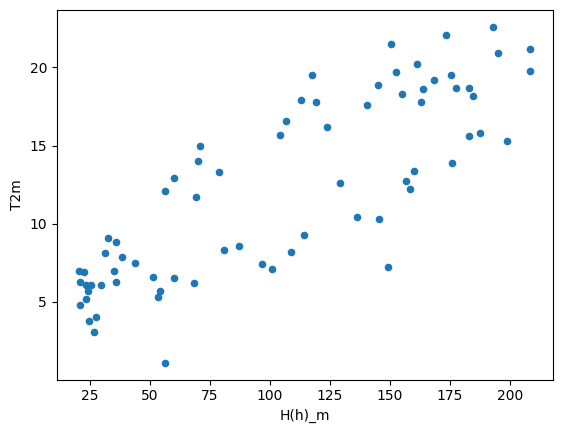

In [9]:
# Example scatter plot of irradiation on horizontal plane with respect to 24 hour averages of temperature
# The plot suggests a direct correlation

df.plot(x='H(h)_m', y='T2m', kind='scatter')

# Replacing the month names with integer values to create time-series data

In [10]:
# Mapping integer values to month names

mapping = {'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}

In [11]:
# Replacing month names with the mapping

df = df.replace({'month': mapping})

C:\Users\ugurhan\AppData\Local\Temp\ipykernel_10988\1706021686.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({'month': mapping})


In [12]:
# Copying main dataframe in case of failure

df_copy = df

In [13]:
df_copy

,year,month,H(h)_m,Hb(n)_m,T2m
0,2018,1,22.68,23.09,6.9
1,2018,2,56.19,81.70,1.1
2,2018,3,68.33,52.06,6.2
3,2018,4,129.35,121.83,12.6
4,2018,5,187.56,174.29,15.8
...,...,...,...,...,...
67,2023,8,145.23,120.93,18.9
68,2023,9,117.72,129.83,19.5
69,2023,10,70.07,81.76,14.0
70,2023,11,31.46,38.65,8.1


In [14]:
# Merging columns to get data similar to a date

df_copy['ColumnA'] = df.iloc[:,0:2].apply(lambda x: "-".join(x.astype(str)), axis=1)

In [15]:
df_copy

,year,month,H(h)_m,Hb(n)_m,T2m,ColumnA
0,2018,1,22.68,23.09,6.9,2018-1
1,2018,2,56.19,81.70,1.1,2018-2
2,2018,3,68.33,52.06,6.2,2018-3
3,2018,4,129.35,121.83,12.6,2018-4
4,2018,5,187.56,174.29,15.8,2018-5
...,...,...,...,...,...,...
67,2023,8,145.23,120.93,18.9,2023-8
68,2023,9,117.72,129.83,19.5,2023-9
69,2023,10,70.07,81.76,14.0,2023-10
70,2023,11,31.46,38.65,8.1,2023-11


In [16]:
# Dropping columns to clean the dataframe

df_copy['year'] = df_copy['ColumnA']

In [17]:
df_copy = df_copy.drop(['ColumnA'], axis=1)

df_copy

,year,month,H(h)_m,Hb(n)_m,T2m
0,2018-1,1,22.68,23.09,6.9
1,2018-2,2,56.19,81.70,1.1
2,2018-3,3,68.33,52.06,6.2
3,2018-4,4,129.35,121.83,12.6
4,2018-5,5,187.56,174.29,15.8
...,...,...,...,...,...
67,2023-8,8,145.23,120.93,18.9
68,2023-9,9,117.72,129.83,19.5
69,2023-10,10,70.07,81.76,14.0
70,2023-11,11,31.46,38.65,8.1


In [18]:
df_copy = df_copy.drop(['month'], axis=1)

df_copy

,year,H(h)_m,Hb(n)_m,T2m
0,2018-1,22.68,23.09,6.9
1,2018-2,56.19,81.70,1.1
2,2018-3,68.33,52.06,6.2
3,2018-4,129.35,121.83,12.6
4,2018-5,187.56,174.29,15.8
...,...,...,...,...
67,2023-8,145.23,120.93,18.9
68,2023-9,117.72,129.83,19.5
69,2023-10,70.07,81.76,14.0
70,2023-11,31.46,38.65,8.1


In [19]:
df_copy = df_copy.rename(columns={"year": "date"})

<Axes: xlabel='date', ylabel='Average temperature'>

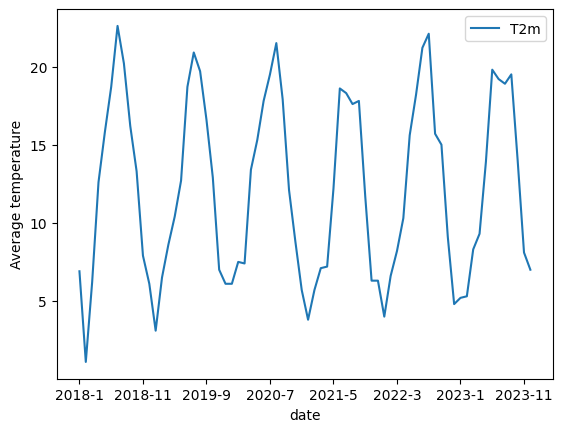

In [ ]:
# An example plot to see average temperature values with regards to date

df_copy.plot(x='date', y='T2m', kind='line', ylabel='Average temperature')

In [79]:
# Drop date column to convert all values to floating point values
# More suitable for modeling with a neural network

df_copy_dateless = df_copy.drop(['date'], axis=1)

# Temperature Prediction

In [55]:
df_copy_dateless = df_copy_dateless.iloc[:, [2]]

df_copy_dateless

,T2m
0,6.9
1,1.1
2,6.2
3,12.6
4,15.8
...,...
67,18.9
68,19.5
69,14.0
70,8.1


In [56]:
# Preparing dataset for LSTM training

df_lstm = df_copy_dateless.values
df_lstm = df_lstm.astype('float32')

In [57]:
# normalize the dataset

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm = scaler.fit_transform(df_lstm)

In [58]:
# split into train and test sets

train_size = int(len(df_lstm) * 0.80)
test_size = len(df_lstm) - train_size
train, test = df_lstm[0:train_size,:], df_lstm[train_size:len(df_lstm),:]
print(len(train), len(test))

57 15


In [59]:
# convert an array of values into a dataset matrix

def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [60]:
# reshape into X=t and Y=t+1

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [62]:
# reshape input to be [samples, time steps, features]

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [63]:
np.shape(trainX)

(55, 1, 1)

In [64]:
# create and fit the LSTM network

model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100


d:\Users\ugurhan\Desktop\LSTM Model\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


55/55 - 2s - 30ms/step - loss: 0.3377
Epoch 2/100
55/55 - 0s - 6ms/step - loss: 0.2635
Epoch 3/100
55/55 - 0s - 6ms/step - loss: 0.2016
Epoch 4/100
55/55 - 0s - 6ms/step - loss: 0.1515
Epoch 5/100
55/55 - 0s - 6ms/step - loss: 0.1135
Epoch 6/100
55/55 - 0s - 6ms/step - loss: 0.0872
Epoch 7/100
55/55 - 0s - 6ms/step - loss: 0.0708
Epoch 8/100
55/55 - 0s - 6ms/step - loss: 0.0614
Epoch 9/100
55/55 - 0s - 6ms/step - loss: 0.0562
Epoch 10/100
55/55 - 0s - 6ms/step - loss: 0.0532
Epoch 11/100
55/55 - 0s - 6ms/step - loss: 0.0513
Epoch 12/100
55/55 - 0s - 6ms/step - loss: 0.0498
Epoch 13/100
55/55 - 0s - 6ms/step - loss: 0.0486
Epoch 14/100
55/55 - 0s - 6ms/step - loss: 0.0474
Epoch 15/100
55/55 - 0s - 6ms/step - loss: 0.0463
Epoch 16/100
55/55 - 0s - 6ms/step - loss: 0.0452
Epoch 17/100
55/55 - 0s - 6ms/step - loss: 0.0442
Epoch 18/100
55/55 - 0s - 6ms/step - loss: 0.0431
Epoch 19/100
55/55 - 0s - 6ms/step - loss: 0.0421
Epoch 20/100
55/55 - 0s - 6ms/step - loss: 0.0411
Epoch 21/100
55/55 -

In [65]:
# make predictions

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error

trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Train Score: 3.31 RMSE
Test Score: 3.66 RMSE


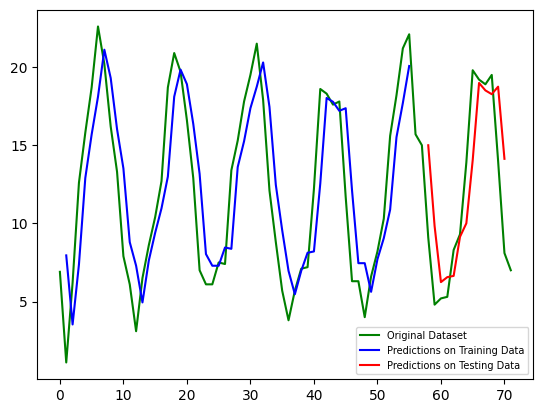

In [75]:
# shift train predictions for plotting

trainPredictPlot = np.empty_like(df_lstm)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting

testPredictPlot = np.empty_like(df_lstm)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(df_lstm)-1, :] = testPredict

# plot baseline and predictions

plt.plot(scaler.inverse_transform(df_lstm), 'g', label='Original Dataset')
plt.plot(trainPredictPlot, 'b', label='Predictions on Training Data')
plt.plot(testPredictPlot, 'r', label='Predictions on Testing Data')
plt.legend(fontsize=7)
plt.show()

# Irradiation Prediction

In [80]:
df_copy_irradiation = df_copy_dateless.iloc[:, [0]]

df_copy_irradiation

,H(h)_m
0,22.68
1,56.19
2,68.33
3,129.35
4,187.56
...,...
67,145.23
68,117.72
69,70.07
70,31.46


In [81]:
# Preparing dataset for LSTM training

df_lstm = df_copy_irradiation.values
df_lstm = df_lstm.astype('float32')

In [82]:
# normalize the dataset

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm = scaler.fit_transform(df_lstm)

In [83]:
# split into train and test sets

train_size = int(len(df_lstm) * 0.80)
test_size = len(df_lstm) - train_size
train, test = df_lstm[0:train_size,:], df_lstm[train_size:len(df_lstm),:]
print(len(train), len(test))

57 15


In [84]:
# convert an array of values into a dataset matrix

def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [85]:
# reshape into X=t and Y=t+1

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [86]:
# reshape input to be [samples, time steps, features]

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [87]:
np.shape(trainX)

(55, 1, 1)

In [88]:
# create and fit the LSTM network

model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100


d:\Users\ugurhan\Desktop\LSTM Model\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


55/55 - 2s - 29ms/step - loss: 0.3646
Epoch 2/100
55/55 - 0s - 6ms/step - loss: 0.2926
Epoch 3/100
55/55 - 0s - 5ms/step - loss: 0.2345
Epoch 4/100
55/55 - 0s - 6ms/step - loss: 0.1873
Epoch 5/100
55/55 - 0s - 6ms/step - loss: 0.1505
Epoch 6/100
55/55 - 0s - 6ms/step - loss: 0.1235
Epoch 7/100
55/55 - 0s - 6ms/step - loss: 0.1050
Epoch 8/100
55/55 - 0s - 6ms/step - loss: 0.0930
Epoch 9/100
55/55 - 0s - 6ms/step - loss: 0.0852
Epoch 10/100
55/55 - 0s - 6ms/step - loss: 0.0799
Epoch 11/100
55/55 - 0s - 5ms/step - loss: 0.0759
Epoch 12/100
55/55 - 0s - 6ms/step - loss: 0.0726
Epoch 13/100
55/55 - 0s - 6ms/step - loss: 0.0696
Epoch 14/100
55/55 - 0s - 6ms/step - loss: 0.0667
Epoch 15/100
55/55 - 0s - 6ms/step - loss: 0.0640
Epoch 16/100
55/55 - 0s - 6ms/step - loss: 0.0613
Epoch 17/100
55/55 - 0s - 6ms/step - loss: 0.0588
Epoch 18/100
55/55 - 0s - 6ms/step - loss: 0.0563
Epoch 19/100
55/55 - 0s - 6ms/step - loss: 0.0539
Epoch 20/100
55/55 - 0s - 6ms/step - loss: 0.0516
Epoch 21/100
55/55 -

In [89]:
# make predictions

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error

trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/stepWARNING:tensorflow:6 out of the last 8 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001984DDFAA20> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Train Score: 31.86 RMSE
Test Score: 34.50 RMSE


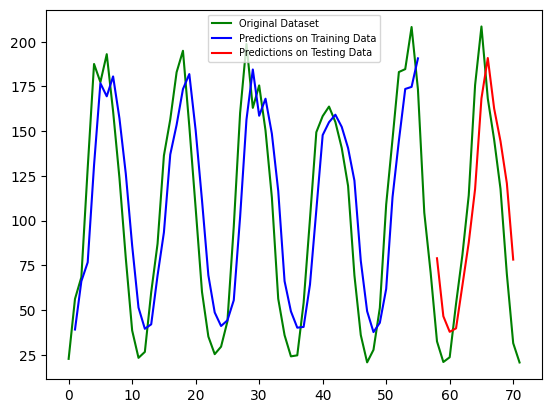

In [90]:
# shift train predictions for plotting

trainPredictPlot = np.empty_like(df_lstm)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting

testPredictPlot = np.empty_like(df_lstm)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(df_lstm)-1, :] = testPredict

# plot baseline and predictions

plt.plot(scaler.inverse_transform(df_lstm), 'g', label='Original Dataset')
plt.plot(trainPredictPlot, 'b', label='Predictions on Training Data')
plt.plot(testPredictPlot, 'r', label='Predictions on Testing Data')
plt.legend(fontsize=7)
plt.show()